This script contains some improvement from train.ipynb by default:
* much few layers, heads, and embedding dimension to reduce the model size
* dataloader v2 which uses a custom tokenizer (again to reduce model size)
* no positional embeddings (to reduce model complexity)
* weight tying (to reduce model size)


We implemented a few things here first and not before:
* validation losses
* increased the model size to be just below 30M parameters
* reduced the amount of data trained with to keep the training (wall) time consistent
* made graph more informative

This script contains a couple improvements from train2.ipynb:
* gradient accumulation is enabled
* the dataloader chunks from the start of an example up to the max_length or the endoftext token

This contains some changes from train3.ipynb:
* an accuracy metric has been implemented
* one cycle learning rate schedule is being used
* weight tying is disabled

This contains some improvements from train4.ipynb: just that the attention module used uses pytorchs implementation for sdpa. This also uses a text generation function to display the capabilities of the trained model.

This contains some changes over train5.ipynb. We use data loading hooks for setting up the train/validation data loaders. We also use the setup hook for setting up the gpt model. We also call compile on the gpt model before training. We also have some code for investigating memory leaks.

The train6 files were used to determine the cause of the memory leak which seems to have been using multiple workers which causes copy-on-reads to occur. setting num_wokers=0 in the dataloader resolves this issue.
See issue: https://github.com/pytorch/pytorch/issues/13246#issuecomment-905703662
blogpost: https://ppwwyyxx.com/blog/2022/Demystify-RAM-Usage-in-Multiprocess-DataLoader/

The train7 files started using datasets processed by huggingface libraries. This file continues from there.

In [1]:
from tokenizers import Tokenizer

tokenizer = Tokenizer.from_file("./TinyStories_tokenizer_small.json")
vocab_size = tokenizer.get_vocab_size()

In [2]:
GPT_CONFIG_30M = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 512,
    "n_heads": 4,
    "n_layers": 4,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": True,
    "no_pos_emb": True
}

In [3]:
GPT_CONFIG_30M_small_emb = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 256,
    "n_heads": 16,
    "n_layers": 18,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": False
}

In [4]:
GPT_CONFIG_60M = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 512,
    "n_heads": 8,
    "n_layers": 8,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": False # conflicts with sequence packing
}

In [5]:
GPT_CONFIG_120M_DEEP = {
    "vocab_size": vocab_size,
    "context_length": 512, # this must be multiple of 64 for the flash attention implementation
    "emb_dim": 512, # this must be multiple of 16 * n_heads for the flash attention implementation
    "n_heads": 32,
    "n_layers": 36,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": False # conflicts with sequence packing
}

In [6]:
GPT_CONFIG_120M_SHALLOW = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 768,
    "n_heads": 64,
    "n_layers": 10,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": False # conflicts with sequence packing
}

In [7]:
import socket
hostname = socket.gethostname().lower()
if "laptop" in hostname:
    GPT_CONFIG = GPT_CONFIG_30M
else:
    GPT_CONFIG = GPT_CONFIG_120M_DEEP

In [8]:
import torch.nn as nn
import torch

torch.set_float32_matmul_precision('medium')

In [9]:
trainer_config = {
    "dataset_scale": 1,
    "batch_size": 32 if "laptop" in hostname else 32,
    "epochs": 2,
    "train_file_loc": "../data/TinyStories/TinyStoriesV2-GPT4-train.txt",
    "valid_file_loc": "../data/TinyStories/TinyStoriesV2-GPT4-valid.txt",
    "num_workers": 23,
    "max_lr": 1e-3,
    "compile": "laptop" not in hostname
}
trainer_config["grad_batches"] = 256 // trainer_config["batch_size"]

In [10]:
from components.gptmodel import GPTModel_v3
from torch.optim.lr_scheduler import OneCycleLR
import lightning as L
from datasets import load_from_disk
from torch.utils.data import DataLoader


class LitGPTModel(L.LightningModule):
    def __init__(self, trainer_config, gpt_config):
        super().__init__()
        self.gpt_config = gpt_config
        self.trainer_config = trainer_config

        self.train_accuracy = []
        self.val_accuracy = []
        self.train_losses = []
        self.val_losses = []
        self.val_steps = []
        self.learning_rates = []
        self.batch_step = 0

    def _accuracy(self, output, expected):
        total_matching = (torch.argmax(output, dim=-1) == expected).sum().item()
        total_numel = expected.numel()
        return total_matching / total_numel

    def training_step(self, batch, batch_idx):
        self.batch_step += 1

        x, y = batch["packed_inputs"][:, :-1], batch["packed_inputs"][:, 1:]
        attn_mask = batch["attention_mask"][:, :-1, :-1]
        logits = self.model([x, attn_mask])

        accuracy = self._accuracy(logits, y)
        self.log("accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.train_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.train_losses.append(loss.item())

        current_lr = self.optimizers().param_groups[0]["lr"]
        self.learning_rates.append(current_lr)

        return loss

    def validation_step(self, batch, batch_idx):
        self.val_steps.append(self.batch_step)
        x, y = batch["packed_inputs"][:, :-1], batch["packed_inputs"][:, 1:]
        attn_mask = batch["attention_mask"][:, :-1, :-1]

        logits = self.model([x, attn_mask])

        accuracy = self._accuracy(logits, y)
        self.log("val_accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.val_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.val_losses.append(loss.item())
        
        return loss

    def loss(self, output, expected):
        loss = nn.functional.cross_entropy(
            output.flatten(0, 1), expected.flatten()
        )
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.trainer_config["max_lr"], weight_decay=0.1
        )

        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.trainer_config["max_lr"],
            total_steps=self.trainer.estimated_stepping_batches,
        )
        print("Total steps: ", self.trainer.estimated_stepping_batches)
        lr_scheduler_config = {
            "scheduler": scheduler,
            "interval": "step",
            "monitor": "loss"
        }

        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler_config
        }

    def setup(self, stage):
        self.packed_dataset = load_from_disk("packed_dataset_with_mask_smallVocab")
        self.packed_dataset.set_format('torch')

    def configure_model(self):
        self.model = GPTModel_v3(self.gpt_config)
        if self.trainer_config["compile"]:
            self.model = torch.compile(self.model, fullgraph=True)


    def train_dataloader(self):
        return DataLoader(
            self.packed_dataset["train"],
            batch_size=self.trainer_config["batch_size"],
            shuffle=True,
            num_workers=self.trainer_config["num_workers"],
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=2,
        )

    def val_dataloader(self):
        return DataLoader(
            self.packed_dataset["validation"],
            batch_size=self.trainer_config["batch_size"],
            shuffle=False,
            num_workers=self.trainer_config["num_workers"],
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=2,
        )


/home/gebrial/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
litmodel = LitGPTModel(
    trainer_config,
    GPT_CONFIG
)

In [12]:
# %%time

trainer = L.Trainer(
    max_epochs=trainer_config["epochs"],
    logger=False,
    enable_progress_bar=True,
    accumulate_grad_batches=trainer_config["grad_batches"],
    gradient_clip_val=1.0,
    enable_checkpointing=True,
    # callbacks=[
    #     L.callbacks.LearningRateMonitor(logging_interval="step"),
    #     L.callbacks.ModelCheckpoint(
    #         monitor="val_loss",
    #         mode="min",
    #         save_top_k=1,
    #         filename="{epoch:02d}-{val_loss:.2f}",
    #         dirpath="./checkpoints/120M_DEEP/"
    #     )
    # ],
    precision="bf16-mixed" #"bf16-mixed", # or "transformer-engine" for 8-bit mixed
)
trainer.fit(model=litmodel)

INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/gebrial/miniforge3/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/gebrial/projects/llm-from-scr

Total steps:  7654
Epoch 1: 100%|██████████| 30611/30611 [1:41:00<00:00,  5.05it/s, accuracy_step=0.671, loss_step=1.210, val_accuracy_step=0.668, val_loss_step=1.230, val_accuracy_epoch=0.694, val_loss_epoch=1.110, accuracy_epoch=0.679, loss_epoch=1.180]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 30611/30611 [1:41:01<00:00,  5.05it/s, accuracy_step=0.671, loss_step=1.210, val_accuracy_step=0.668, val_loss_step=1.230, val_accuracy_epoch=0.694, val_loss_epoch=1.110, accuracy_epoch=0.679, loss_epoch=1.180]


In [24]:
trainer.save_checkpoint(
    "./checkpoints/120M_DEEP_bf16_smallVocab_twoEpochs.ckpt",
)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


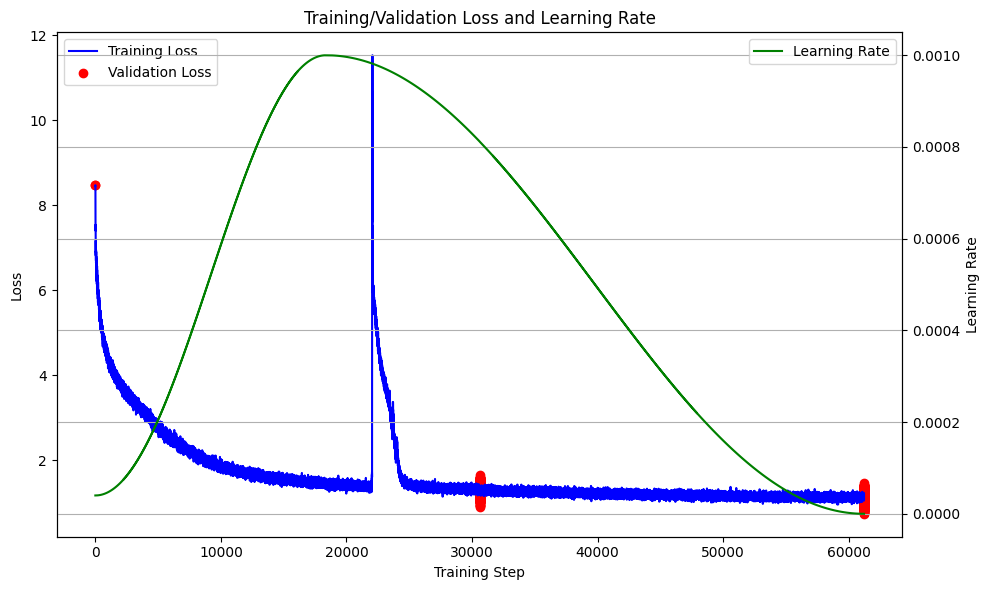

In [14]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(litmodel.train_losses, label="Training Loss", color="blue")
ax1.scatter(litmodel.val_steps, litmodel.val_losses, label="Validation Loss", color="red")
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(litmodel.learning_rates, label="Learning Rate", color="green")
ax2.set_ylabel("Learning Rate")
ax2.legend(loc="upper right")

plt.title("Training/Validation Loss and Learning Rate")
plt.tight_layout()
plt.grid(True)
plt.show()

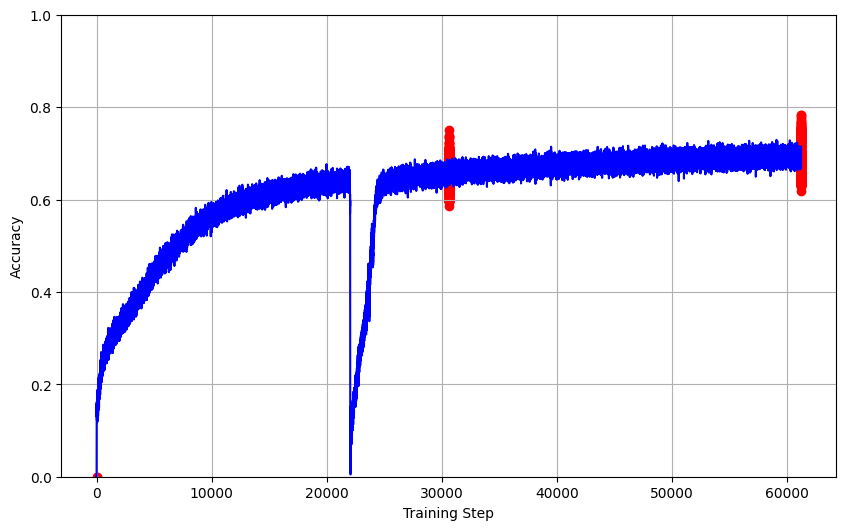

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(litmodel.train_accuracy, color="blue")
plt.scatter(litmodel.val_steps, litmodel.val_accuracy, color="red")
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0, 1)
plt.show()

In [12]:
from tokenizers import Tokenizer

In [13]:
tokenizer = Tokenizer.from_file("./TinyStories_tokenizer_small.json")

In [14]:
from tokenizers import decoders
tokenizer.decoder = decoders.WordPiece()

In [35]:
litmodel = LitGPTModel.load_from_checkpoint(
    "./checkpoints/120M_DEEP_bf16_smallVocab_twoEpochs-duplicateMaybe.ckpt",
    gpt_config=GPT_CONFIG,
    trainer_config=trainer_config,
)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
litmodel.model.to(device)

OptimizedModule(
  (_orig_mod): GPTModel_v3(
    (tok_emb): Embedding(4096, 512)
    (pos_emb): Embedding(512, 512)
    (drop_emb): Dropout(p=0.1, inplace=False)
    (trf_blocks): Sequential(
      (0): TransformerBlock_v3(
        (att): MultiHeadAttention_v3(
          (W_query): Linear(in_features=512, out_features=512, bias=False)
          (W_key): Linear(in_features=512, out_features=512, bias=False)
          (W_value): Linear(in_features=512, out_features=512, bias=False)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): FeedForward(
          (layers): Sequential(
            (0): Linear(in_features=512, out_features=2048, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=2048, out_features=512, bias=True)
          )
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (drop_shortcut)

In [16]:
sum([p.numel() for p in litmodel.model.parameters() if p.requires_grad])

117888000

In [17]:
from components.generatetext import generate_text_with_attn

In [18]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text_with_attn(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom p ours some soup into two bowl s. He gives one bowl to Jane. Jane takes a spoon ful of soup, but then she makes a face. The soup is too salt y. Jane does the same. Jane is embarrassed because she made a mess with the bowl s of soup! Tom laughs. He tells her that she can try again. She tries again. This time she does not feel embarrassed anymore! They enjoy their delicious bowl of yummy soup together. They have fun. The soup tast es like it ' re fresh ing and tast es like a sweet cake!
CPU times: user 1min 39s, sys: 16.6 s, total: 1min 56s
Wall time: 1min 56s


In [19]:
import csv
import time

with open('evaluation_prompts.csv', mode='r') as file:
    csv_reader = csv.DictReader(file)
    data = [row for row in csv_reader]  # Each row is a dictionary

data_len = len(data)
current_index = 0
# measure time
start_time = time.time()
# Modify data (e.g., change 'age' column to integers)
for row in data:
    current_index += 1
    starting_text = row['prompt']
    output_text = generate_text_with_attn(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1, output_only=True)
    row['completion'] = output_text
    if current_index % 1 == 0:
        # print prompt
        print(f"Prompt {current_index}: {starting_text}")
        # print output
        print(f"Row {current_index}: {output_text}")
        current_time = time.time()
        elapsed_time = current_time - start_time
        time_left = (data_len - current_index) * (elapsed_time / current_index)
        print(f"Processed {current_index}/{data_len} rows. Estimated time left: {time_left:.2f} seconds.")


Prompt 1: Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she could
Row 1: hard s ense. She was scared that her friends would not like it, so Lucy started running. She hopped faster than ever before and soon reached her friends, and told them all about the sick bunny in pain. They were so relieved that she wasn ' to be able hurt and they were so happy that Lucy wasn ' ting her wor ries. Lucy and all the friends enjoyed the day together, eating yummy food and playing in their garden s in a big circle. They were all so relieved to be back together and safe again. Lucy learned an important lesson that even if she was small and weak she still had her best friends and that was all she had.
Processed 1/300 rows. Estimated time left: 355.28 seconds.
Prompt 2: Once upon a time, there l

In [20]:
with open('evaluation_outputs.csv', mode='w', newline='') as file:
    fieldnames = data[0].keys()  # Get column names
    csv_writer = csv.DictWriter(file, fieldnames=fieldnames)
    csv_writer.writeheader()
    csv_writer.writerows(data)

In [23]:
data[6]["completion"]

'she heard someone say, â ‚ â ‚ o sity. It was a small mouse, standing in front of her, looking up and asking, â ‚ â „ â € œ Why do you want that big cupboard in our home? â € The mouse replied, in a small, sque aky voice, â ‚ p ted. The mouse was very scared of what was going to happen next and quickly jumped back in fright and quickly ran out. The girl smiled at the mouse as they walked away. The next morning the girl went into her house and saw the cabinet in her living room. She was surprised and curious to find out who had been talking about the cupboard in the first spot. She slowly walked over, pe ep ed in,, until she found a small mouse pee king in. It had been the same size and size the mouse was standing on! She laughed and the mouse smiled. The girl and the small mouse had become friends and they were happy to have a new friend!'

In [27]:
data_encoding = tokenizer.encode(data[6]["completion"])

In [32]:
zipped = zip(data_encoding.ids, data_encoding.tokens)
# print zipped
[print(f"{token}: {id}") for id, token in zipped]

she: 329
heard: 734
someone: 1480
say: 484
,: 16
â: 114
‚: 152
â: 114
‚: 152
o: 82
sity: 3440
.: 18
It: 351
was: 238
a: 68
small: 480
mouse: 921
,: 16
standing: 2798
in: 229
front: 2146
of: 256
her: 279
,: 16
looking: 987
up: 301
and: 228
asking: 2577
,: 16
â: 114
‚: 152
â: 114
„: 155
â: 114
€: 158
œ: 126
Why: 1019
do: 318
you: 290
want: 470
that: 327
big: 289
cupboard: 3340
in: 229
our: 666
home: 495
?: 35
â: 114
€: 158
The: 236
mouse: 921
replied: 1299
,: 16
in: 229
a: 68
small: 480
,: 16
sque: 2366
aky: 3479
voice: 1123
,: 16
â: 114
‚: 152
p: 83
ted: 293
.: 18
The: 236
mouse: 921
was: 238
very: 292
scared: 523
of: 256
what: 498
was: 238
going: 985
to: 227
happen: 1486
next: 862
and: 228
quickly: 1358
jumped: 826
back: 441
in: 229
fright: 2470
and: 228
quickly: 1358
ran: 460
out: 367
.: 18
The: 236
girl: 416
smiled: 482
at: 261
the: 225
mouse: 921
as: 336
they: 303
walked: 700
away: 497
.: 18
The: 236
next: 862
morning: 1623
the: 225
girl: 416
went: 373
into: 618
her: 279
house: 517


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [33]:
tokenizer.get_vocab()

{'turkey': 3074,
 'ation': 1437,
 'happening': 3141,
 'Fred': 1672,
 'baby': 1265,
 'grass': 1124,
 'Luna': 1980,
 'izzy': 2096,
 'which': 2480,
 'mad': 486,
 'deaf': 2957,
 'ane': 908,
 'ote': 1598,
 'ames': 1288,
 'veterinarian': 4064,
 'torn': 2923,
 'bow': 1262,
 'banan': 2100,
 'bathroom': 2566,
 'reliable': 2871,
 '\ue000': 213,
 'returned': 3137,
 'lawyer': 4050,
 'vol': 3036,
 'pick': 1108,
 'em': 1302,
 'felt': 466,
 'issors': 2352,
 'spread': 2416,
 'ible': 1655,
 'i': 76,
 'Ow': 2681,
 'unlock': 3288,
 'leash': 3514,
 'most': 1504,
 'cone': 2451,
 'falling': 3705,
 'ner': 1229,
 'kept': 968,
 'n': 81,
 'meat': 3249,
 'create': 3025,
 'troph': 3450,
 'run': 626,
 'Sue': 426,
 'explained': 2695,
 'disappeared': 3355,
 'attach': 3770,
 'saved': 2161,
 'dist': 1878,
 'blouse': 3812,
 'river': 1201,
 'bathtub': 3436,
 'bushes': 3223,
 'other': 440,
 'raz': 3756,
 'wall': 1227,
 'Why': 1019,
 'your': 536,
 'jealous': 2483,
 'couch': 2207,
 'dive': 3284,
 'ife': 2594,
 'ur': 390,
 

In [36]:
# run validation set only
trainer = L.Trainer(
    max_epochs=trainer_config["epochs"],
    logger=False,
    enable_progress_bar=True,
    accumulate_grad_batches=trainer_config["grad_batches"],
    gradient_clip_val=1.0,
    enable_checkpointing=True,
    # callbacks=[
    #     L.callbacks.LearningRateMonitor(logging_interval="step"),
    #     L.callbacks.ModelCheckpoint(
    #         monitor="val_loss",
    #         mode="min",
    #         save_top_k=1,
    #         filename="{epoch:02d}-{val_loss:.2f}",
    #         dirpath="./checkpoints/120M_DEEP/"
    #     )
    # ],
    precision="bf16-mixed" #"bf16-mixed", # or "transformer-engine" for 8-bit mixed
)
trainer.validate(model=litmodel)


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 308/308 [00:25<00:00, 11.95it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    val_accuracy_epoch     │   0.0001312258973484859   │
│      val_loss_epoch       │     8.502946853637695     │
└───────────────────────────┴───────────────────────────┘

[{'val_accuracy_epoch': 0.0001312258973484859,
  'val_loss_epoch': 8.502946853637695}]

In [ ]:
# run validation set only
trainer = L.Trainer(
    max_epochs=trainer_config["epochs"],
    logger=False,
    enable_progress_bar=True,
    accumulate_grad_batches=trainer_config["grad_batches"],
    gradient_clip_val=1.0,
    enable_checkpointing=True,
    # callbacks=[
    #     L.callbacks.LearningRateMonitor(logging_interval="step"),
    #     L.callbacks.ModelCheckpoint(
    #         monitor="val_loss",
    #         mode="min",
    #         save_top_k=1,
    #         filename="{epoch:02d}-{val_loss:.2f}",
    #         dirpath="./checkpoints/120M_DEEP/"
    #     )
    # ],
    precision="bf16-mixed" #"bf16-mixed", # or "transformer-engine" for 8-bit mixed
)
trainer.validate(model=litmodel)


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 308/308 [00:51<00:00,  5.94it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    val_accuracy_epoch     │   0.0005389776779338717   │
│      val_loss_epoch       │     8.44394588470459      │
└───────────────────────────┴───────────────────────────┘

[{'val_accuracy_epoch': 0.0005389776779338717,
  'val_loss_epoch': 8.44394588470459}]